In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"heenafirdouse","key":"87919880e093fbc8a9a984e56b8639e9"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d samaneheslamifar/facial-emotion-expressions

 96% 116M/121M [00:00<00:00, 175MB/s] 
100% 121M/121M [00:00<00:00, 157MB/s]


In [ ]:
#!unzip /content/facial-emotion-expressions.zip

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((48, 48)),#[1]resized to a height of 48 pixels and a width of 48 pixels. 
    transforms.RandomHorizontalFlip(),#[1]
    transforms.ToTensor(),#[1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))#[2]
])

val_transforms = transforms.Compose([
    transforms.Resize((48, 48)),#[1]
    transforms.ToTensor(),#[1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))#[2]
])

In [ ]:
train_data = datasets.ImageFolder("/content/images/train", transform=train_transforms)#[1]
val_data = datasets.ImageFolder("/content/images/validation", transform=val_transforms)#[1]
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(val_data)}")

Number of training examples: 28821
Number of validation examples: 7066


<ipython-input-18-086de3b8dafe>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories, rotation=10)


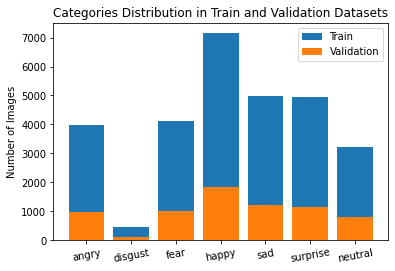

In [ ]:
#plot the distribution of categories in the training and validation datasets
import numpy as np
categories = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

# number of examples per class in the training data
train_example = []
for i in range(7):
    train_example.append(np.sum(np.array(train_data.targets) == i))

#  number of examples per class in the validation data
val_example = []
for i in range(7):
    val_example.append(np.sum(np.array(val_data.targets) == i))

fig, ax = plt.subplots()
ax.bar(categories, train_example, label='Train')
ax.bar(categories, val_example, label='Validation')
ax.set_xticklabels(categories, rotation=10)
ax.legend()
ax.set_ylabel('Number of Images')
ax.set_title('Categories Distribution in Train and Validation Datasets')
plt.show()

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
#CNN architecture

class CNN(nn.Module):
    def __init__(self):#[3]
        super(CNN, self).__init__()[3]
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)#[3] updated parameters kernel size and padding
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)#[3] updated parameters kernel size and padding
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)[3]
        self.fc1 = nn.Linear(32 * 12 * 12, 512)#[3] updated output size
        self.fc2 = nn.Linear(512, 7)#[3]

    def forward(self, x):#[3]
        x = self.pool(torch.relu(self.conv1(x)))#[3]
        x = self.pool(torch.relu(self.conv2(x)))#[3]
        x = x.view(-1, 32 * 12 * 12)#[3]
        x = torch.relu(self.fc1(x))#[3]
        x = self.fc2(x)#[3]
        return x

cnn = CNN()


In [ ]:
# the loss function and optimizer
criterion = nn.CrossEntropyLoss()#[3] 
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)#[3]

In [ ]:
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

epochs = 10 #number of epochs 10
batch_size = 32 #batch size set to 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)#[3]
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)#[3]


for epoch in range(epochs):#[3]
    val_loss = 0.0 #[3]
    running_loss = 0.0 #[3]
    train_correct = 0 #[3]
    train_total = 0#[3]
    cnn.train()#[3]
    for i, (inputs, labels) in enumerate(train_loader):#[3]
        optimizer.zero_grad()#[3]
        outputs = cnn(inputs)#[3]
        loss = criterion(outputs, labels)#[3]
        loss.backward()#[3]
        optimizer.step()#[3]
        running_loss += loss.item()#[3]

        _, predicted = torch.max(outputs.data, 1)#[3]
        train_total += labels.size(0)#[3]
        train_correct += (predicted == labels).sum().item()#[3]
    train_accuracy = 100 * train_correct / train_total#[3]]#added training accuracy
    train_loss = running_loss / len(train_loader)#[3]
    train_loss_values.append(train_loss)#[3]
    train_accuracy_values.append(train_accuracy)#[3]

    cnn.eval()#[3]
    val_correct = 0#[3]
    val_total = 0#[3]
    with torch.no_grad():#[3]
        for images, labels in val_loader:#[3]
            outputs = cnn(images)#[3]
            loss = criterion(outputs, labels)#[3]
            val_loss += loss.item()#[3]
            _, predicted = torch.max(outputs.data, 1)#[3]
            val_total += labels.size(0)#[3]
            val_correct += (predicted == labels).sum().item()#[3]

    val_accuracy = 100 * val_correct / val_total#[3]
    val_loss = val_loss / len(val_loader)#[3] #added validation loss
    val_loss_values.append(val_loss)#[3]
    val_accuracy_values.append(val_accuracy)#[3]

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.2f}, Val Accuracy: {val_accuracy:.2f}%")#[3] 



Epoch [1/10], Train Loss: 1.69, Train Accuracy: 32.40%, Val Loss: 1.58, Val Accuracy: 38.04%
Epoch [2/10], Train Loss: 1.49, Train Accuracy: 42.41%, Val Loss: 1.39, Val Accuracy: 47.14%
Epoch [3/10], Train Loss: 1.39, Train Accuracy: 46.41%, Val Loss: 1.32, Val Accuracy: 48.73%
Epoch [4/10], Train Loss: 1.32, Train Accuracy: 49.48%, Val Loss: 1.26, Val Accuracy: 51.15%
Epoch [5/10], Train Loss: 1.26, Train Accuracy: 51.76%, Val Loss: 1.23, Val Accuracy: 53.37%
Epoch [6/10], Train Loss: 1.21, Train Accuracy: 53.67%, Val Loss: 1.20, Val Accuracy: 54.68%
Epoch [7/10], Train Loss: 1.17, Train Accuracy: 55.45%, Val Loss: 1.19, Val Accuracy: 55.08%
Epoch [8/10], Train Loss: 1.13, Train Accuracy: 56.84%, Val Loss: 1.21, Val Accuracy: 55.42%
Epoch [9/10], Train Loss: 1.09, Train Accuracy: 58.47%, Val Loss: 1.20, Val Accuracy: 55.45%
Epoch [10/10], Train Loss: 1.06, Train Accuracy: 59.90%, Val Loss: 1.19, Val Accuracy: 56.40%


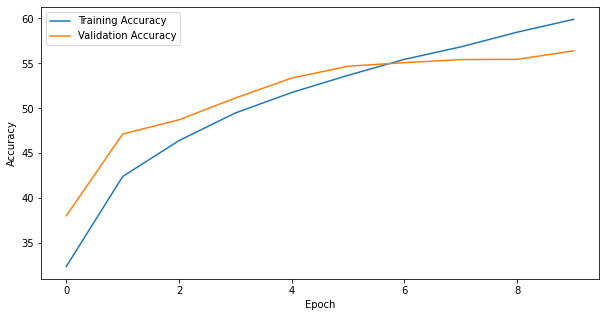

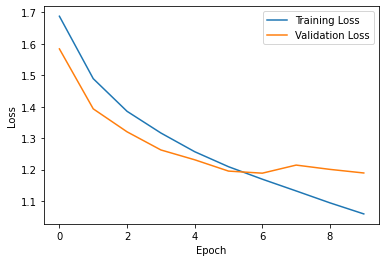

In [ ]:
plt.figure(figsize=(10, 5))
# Plot training and validation accuracy values
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss values
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**References:**

[1]: the article "Transfer Learning with PyTorch" by Pranjal Sharma on Towards Data Science.
#https://towardsdatascience.com/transfer-learning-with-pytorch-95dd5dca82a

[2]:"PyTorch: Data loading and preprocess tutorial  #https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

[3]: Deep Learning Wizard. (n.d.). PyTorch 
Convolutional Neural Network Tutorial. Retrieved March 18, 2023, from https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_convolutional_neuralnetwork/

